This note book focusses on Entitiy Recognition and the subsequent Entity Linking.
Below is a short description about the notebook:

**Named Entity Recognition and Disambiguation (NERD)**: consists of 2 tasks, NER and NED. Since the requirements document mentioned the entities label which were not being supported in the original NER model, I show how we can add the labels and train our custom NER model. (I have trained the model for all the labels but the example code shows how we can do that, just more annotated data will be required).

After this I create a Knowledge Base (KB), where I have shown an example of 3 imaginary companies which have ambiguous aliases. The KB maintains the candidate entities for ambiguous entities which will be used in Entity Linker to decide which candidate is the best match.

After this I train the Entity Linker on custom annotated data, which learns to disambiguate the names based on context from the input sentence and the context vectors saved from the Knowledge Base along with the prior probabilities.

At the end I test the NLP pipeline on an example input.

As an example of why entity disambiguation is important (and why I am using this technique to perform just a simple task of grouping cities or companies by names and short forms):

If the user/document specifies the city name "London" in the text, the NER model will be able to correctly classify it as "Location" label but we can cannot say for sure which city we are talking about unless some more context is provided. If you search how many places in the world are called London you would find something like this:
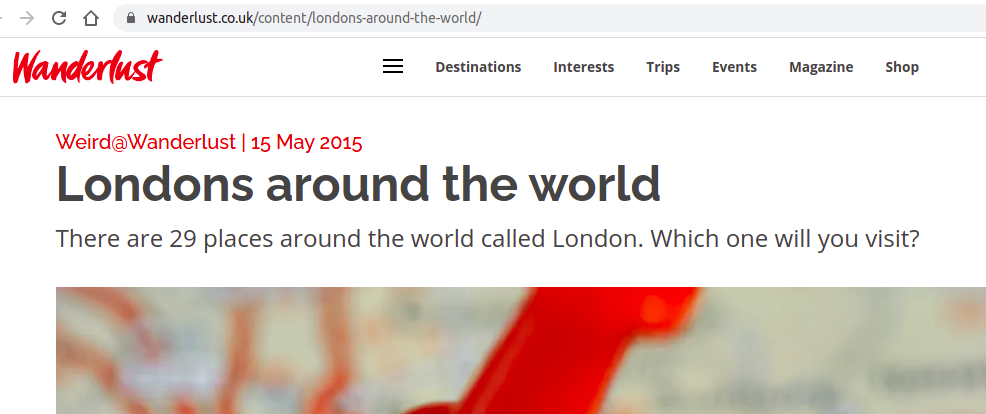

# Custom Entity Recognition:
The first task is to build a custom entity recognition model so that we can assign our custom labels to the entities we want to detect in a sentence. The below code shows how we can do this using SpaCy.

First we install SpaCy and the required large english model for this code.

In [ ]:
!pip install spacy==2.2.4
!python -m spacy download en_core_web_lg

In [88]:
import en_core_web_lg

In [89]:
import spacy
from spacy import displacy
from collections import Counter
nlp = en_core_web_lg.load()

In [90]:
doc = nlp("Walmart issues widespread ban on plastic products")
for x in doc.ents:
    print(x.text, x.label_)


Walmart GPE


so we see that model currently doesnt correctly idenify the company name Walmart, and is identifying it as Geographic Location.

In [ ]:
#doc.to_json()

In [91]:
ner=nlp.get_pipe('ner')
ner

Below is the custom training data which we use to train the NER model and also add the new labels we are wanting to use. Annotation tools are available which can make this process easier.

In [92]:
# training data
TRAIN_DATA = [
              ("Walmart is a leading e-commerce company", {"entities": [(0, 7, "ORG")]}),
              ("M&S is a leading e-commerce company", {"entities": [(0, 3, "ORG")]}),
              ("M&S is one of the organisation which does not run for profit", {"entities": [(0, 3, "ORG")]}),
              ("M&S produces some of the finest goods in the market", {"entities": [(0, 3, "ORG")]}),
              ("I reached Chennai yesterday.", {"entities": [(19, 28, "GPE")]}),
              ("I recently ordered a book from Amazon", {"entities": [(24,32, "ORG")]}),
              ("I was driving a BMW", {"entities": [(16,19, "PRODUCT")]}),
              ("I ordered this from ShopClues", {"entities": [(20,29, "ORG")]}),
              ("Fridge can be ordered in Amazon ", {"entities": [(0,6, "PRODUCT")]}),
              ("I bought a new Washer", {"entities": [(16,22, "PRODUCT")]}),
              ("I bought a old table", {"entities": [(16,21, "PRODUCT")]}),
              ("I bought a fancy dress", {"entities": [(18,23, "PRODUCT")]}),
              ("I rented a camera", {"entities": [(12,18, "PRODUCT")]}),
              ("I rented a tent for our trip", {"entities": [(12,16, "PRODUCT")]}),
              ("I rented a screwdriver from our neighbour", {"entities": [(12,22, "PRODUCT")]}),
              ("I repaired my computer", {"entities": [(15,23, "PRODUCT")]}),
              ("I got my clock fixed", {"entities": [(16,21, "PRODUCT")]}),
              ("I got my truck fixed", {"entities": [(16,21, "PRODUCT")]}),
              ("Flipkart started it's journey from zero", {"entities": [(0,8, "ORG")]}),
              ("I recently ordered from Max", {"entities": [(24,27, "ORG")]}),
              ("Flipkart is recognized as leader in market",{"entities": [(0,8, "ORG")]}),
              ("I recently ordered from Swiggy", {"entities": [(24,29, "ORG")]})
              ]

In [93]:
# Adding labels to the `ner`
ner=nlp.get_pipe('ner')
for _, annotations in TRAIN_DATA:
  for ent in annotations.get("entities"):
    ner.add_label(ent[2])

In [94]:
# Disable pipeline components you dont need to change
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

In [ ]:
# Import requirements
import random
from spacy.util import minibatch, compounding
from pathlib import Path

# TRAINING THE MODEL
with nlp.disable_pipes(*unaffected_pipes):

  # Training for 30 iterations
  for iteration in range(50):

    # shuufling examples  before every iteration
    random.shuffle(TRAIN_DATA)
    losses = {}
    # batch up the examples using spaCy's minibatch
    batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        texts, annotations = zip(*batch)
        nlp.update(
                    texts,  # batch of texts
                    annotations,  # batch of annotations
                    drop=0.5,  # dropout - make it harder to memorise data
                    losses=losses,
                )
        print("Losses", losses)

In [96]:
tex_input='''Walmart issues widespread ban on plastic products'''

In [97]:
# Testing the model
doc = nlp(tex_input)
print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

Entities [('Walmart', 'ORG')]


so now the model correctly identifies Walmart as ORG

In [98]:
# Testing the model
tex_input='''M&S issues widespread ban on plastic products'''
doc = nlp(tex_input)
print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

Entities [('M&S', 'ORG')]


In this similar way we can train the NER model to add additional labels and train the model to detect them.

# Knowledge Base:
Now I will create the knowledge Base which will contain a unique entitiy id, description vector, prior probabaility for each of the entities. Then I also add the aliases which basically store the candidate entities.

I am loading the data from a csv file `entities.csv` and creating the Knowledge Base for 3 imaginary companies, which could have ambiguous mentions.

In [99]:
import csv
from pathlib import Path

def load_entities():
    entities_loc = "/content/entities.csv"#Path.cwd().parent / "input" / "entities.csv"  # distributed alongside this notebook

    names = dict()
    descriptions = dict()
    with open("/content/entities.csv") as csvfile:
    #with entities_loc.open("r", encoding="utf8") as csvfile:
        csvreader = csv.reader(csvfile, delimiter=",")
        for row in csvreader:
            qid = row[0]
            name = row[1]
            desc = row[2]
            names[qid] = name
            descriptions[qid] = desc
    return names, descriptions

Below you can see the contents of entities.csv converted into a dictionary

In [100]:
name_dict, desc_dict = load_entities()
for QID in name_dict.keys():
    print(f"{QID}, name={name_dict[QID]}, desc={desc_dict[QID]}")

Q3145, name=M&S NGO, desc=A non-governmental organization. These are not for profit organizations, many of them are active in humanitarianism or the social sciences
Q4289, name=M&S Manufacturers, desc=Manufacturers of wood items. Specialize in creating custom hardwood tables
Q9673, name=M&S Limited, desc=A major British multinational retailer with headquarters in London, England, that specialises in selling clothing, home products and food products, mostly of its own label.


We have 3 entries here, of 3 different imaginary companies and all 3 can be referred to as M&S. We convert this information into vectors and store in our knowledge base. We need to define a fixed dimensionality for the entity vectors, which will be 300-D in our case.

In [101]:
from spacy.kb import KnowledgeBase
kb = KnowledgeBase(vocab=nlp.vocab, entity_vector_length=300)

The descriptions are converted into vectors using the pre trained word vectors from the nlp model we imported. The final vectors for each description will be the average of the vectors of the token.

In [102]:
# the en_core_web_lg has the apprpriate size vectors, not the sm model
for qid, desc in desc_dict.items():
    desc_doc = nlp(desc)
    desc_enc = desc_doc.vector
    kb.add_entity(entity=qid, entity_vector=desc_enc, freq=342)   # 342 is an arbitrary value here

Now I can add aliases in the KB. If full name is mentioned of the company then we can be sure in our case which entity we are referring to. So we add the probabaility as 1 for these full entity names.

In [103]:
for qid, name in name_dict.items():
    kb.add_alias(alias=name, entities=[qid], probabilities=[1])   # 100% prior probability P(entity|alias)

Since M&S can refer to any of the three companies I have assumed, I need to add the M&S alias and the 3 companies which are candidates for this alias. I have assumed that they are equally probable (same prior probabaility) and thus assigned 0.3 to each entity.

In [104]:
qids = name_dict.keys()
probs = [0.3 for qid in qids]
kb.add_alias(alias="M&S", entities=qids, probabilities=probs)  # sum([probs]) should be <= 1 !

2170877917551562217

So this will be our Knowledge base. We can check the entities and aliases that are contained in it:

In [105]:
print(f"Entities in the KB: {kb.get_entity_strings()}")
print(f"Aliases in the KB: {kb.get_alias_strings()}")

Entities in the KB: ['Q3145', 'Q9673', 'Q4289']
Aliases in the KB: ['M&S Limited', 'M&S NGO', 'M&S', 'M&S Manufacturers']


you can try prinitng the candidate entities from the Knowledge Base as shown below.

In [106]:
print(f"Candidates for 'M&S Limited': {[c.entity_ for c in kb.get_candidates('M&S Limited')]}")
print(f"Candidates for 'M&S': {[c.entity_ for c in kb.get_candidates('M&S')]}")
print(f"Candidates for 'Tesco': {[c.entity_ for c in kb.get_candidates('Tesco')]}")

Candidates for 'M&S Limited': ['Q9673']
Candidates for 'M&S': ['Q3145', 'Q4289', 'Q9673']
Candidates for 'Tesco': []


So here you can see that if I query the KB with M&S we get the 3 candidate entities.

Now obviuously in production systems this will not be done manually. In those scenarios Wikidata or Wikipedia data will be parsed by the system automatically which will store the aliases by using the intrawiki links.This is a heavy process and sometimes only a fraction of the data is used to create the KB. For example when the results of Entity Linker model were being presented by SpaCy they only used 14% of all the entities present in the full data, but they were still able to achieve 84.2 percent accuracy.
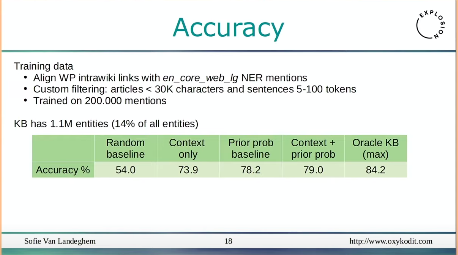

An example of how the aliases are being stored from the wikipedia:

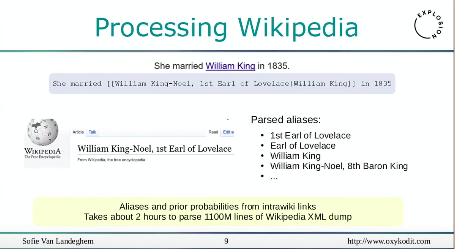

For example in the senetence "She married William King in 1835" the entity William King will have a link to another Wikipedia page (intrawiki link) which will have a more descriptive headline as "William King-Noel, 1st Earl of Lovelace". This mapping thus can be used to create the aliases and stored in the KB. The image shows some examples of other aliases which referred to the William King we are talking about. Thus you have all the various names of William King which can be used to refer to him.

Now, we can save the knowledge base by calling the function 'dump' with an output location.

In [107]:
# change the directory and file names to whatever you like
import os
output_dir = Path.cwd()/"my_output"
if not os.path.exists(output_dir):
    os.mkdir(output_dir) 
kb.dump(output_dir / "my_kb")

We can store the `nlp` object to file by calling `to_disk`.

In [108]:
nlp.to_disk(output_dir / "my_nlp")

# Training dataset

Now we need to train the entity linking model and for that we need some annotated data. Prodigy can be used for this purpose or maybe some other tool but as of now I have made some manually annotated data in a jsonl format file. Refer `annotated_text.jsonl`

Let's have a look at the results in this file:

In [109]:
import json
from pathlib import Path

json_loc = Path.cwd()/ "annotated_text.jsonl"
with json_loc.open("r", encoding="utf8") as jsonfile:
    line = jsonfile.readline()
    print(line)   # print just the first line

{"text":"Since there is no help provided by the government to M&S, it is mostly run by charity funds.","spans":[{"start":53,"end":56,"text":"M&S","rank":0,"label":"ORG","score":1,"source":"en_core_web_lg","input_hash":2024197919}],"accept":["Q3145"],"answer":"accept"}



The most important bit is stored with the key `accept` at the end: this is the value of my manual annotation.
Here you can see that for this specific mention of M&S the entity `Q3145` has been selected. This data will be used for training the Entity Linker.


# Training the Entity Linker

The entity linker takes as input several things:
1. Input sentence context
2. Ner label that was assigned by the NER model
3. Prior probabaility of the candidate entity
4. The entity description from the KB

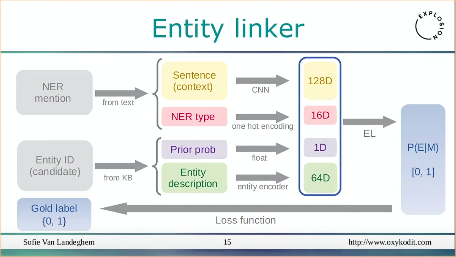

Using just the context or just the prior probabailites will not reveal that good results as we have seen in the expereiments done by Explosion. And thus this model tries to incorporate all the possible information and trains a neural net to perform the classification.


To feed training data into our Entity Linker, we need to format our data as a structured tuple. The first part is the raw text, and the second part is a dictionary of annotations. This dictionary requires the `links` keyword, which holds another dictionary mapping a character offset to the correct identifier.

In [110]:
import json
from pathlib import Path

dataset = []
json_loc = Path.cwd()/ "annotated_text.jsonl"
with json_loc.open("r", encoding="utf8") as jsonfile:
    for line in jsonfile:
        example = json.loads(line)
        text = example["text"]
        if example["answer"] == "accept":
            QID = example["accept"][0]
            offset = (example["spans"][0]["start"], example["spans"][0]["end"])
            links_dict = {QID: 1.0}
        dataset.append((text, {"links": {offset: links_dict}}))

To check whether the conversion looks OK, we can just print the first sample in our dataset. 

In [111]:
dataset[0]

('Since there is no help provided by the government to M&S, it is mostly run by charity funds.',
 {'links': {(53, 56): {'Q3145': 1.0}}})

We can also check some statistics in this dataset. How many cases of each QID do we have annotated?

In [112]:
gold_ids = []
for text, annot in dataset:
    for span, links_dict in annot["links"].items():
        for link, value in links_dict.items():
            if value:
                gold_ids.append(link)

from collections import Counter
print(Counter(gold_ids))

Counter({'Q3145': 3, 'Q4289': 3, 'Q9673': 3})


In [113]:
import random

train_dataset = []
test_dataset = []
for QID in qids:
    indices = [i for i, j in enumerate(gold_ids) if j == QID]
    train_dataset.extend(dataset[index] for index in indices[0:1])  # first 8 in training
    test_dataset.extend(dataset[index] for index in indices[2:2])  # last 2 in test
    
random.shuffle(train_dataset)
random.shuffle(test_dataset)

With our datasets now properly set up, we'll first run each of our training sentences through the pipeline with the NER component.

In [114]:
TRAIN_DOCS = []
for text, annotation in train_dataset:
    doc = nlp(text)     # to make this more efficient, you can use nlp.pipe() just once for all the texts
    TRAIN_DOCS.append((doc, annotation))
    print(doc,annotation)

Since there is no help provided by the government to M&S, it is mostly run by charity funds. {'links': {(53, 56): {'Q3145': 1.0}}}
M&S is known for manufacturing excellent quality wood tables and chairs. {'links': {(0, 3): {'Q4289': 1.0}}}
If you want to buy any clothing, food or home items you should definetly try M&S {'links': {(77, 80): {'Q9673': 1.0}}}


Then, I create a new Entity Linking component and add it to the pipeline.

In [115]:
entity_linker = nlp.create_pipe("entity_linker", config={"incl_prior": False})
entity_linker.set_kb(kb)
nlp.add_pipe(entity_linker, last=True)

Next, I run the actual training loop for the new component, where I train only the Entity Linker model and disabling the other components. 

In [116]:
from spacy.util import minibatch, compounding

other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "entity_linker"]
with nlp.disable_pipes(*other_pipes):   # train only the entity_linker
    optimizer = nlp.begin_training()
    for itn in range(500):   # 500 iterations takes about a minute to train
        random.shuffle(TRAIN_DOCS)
        batches = minibatch(TRAIN_DOCS, size=compounding(4.0, 32.0, 1.001))  # increasing batch sizes
        losses = {}
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(
                texts,  
                annotations,   
                drop=0.2,      # prevent overfitting
                losses=losses,
                sgd=optimizer,
            )
        if itn % 50 == 0:
            print(itn, "Losses", losses)   # print the training loss
print(itn, "Losses", losses)

0 Losses {'entity_linker': 0.9671445687611898}
50 Losses {'entity_linker': 0.07804141441980998}
100 Losses {'entity_linker': 0.033703366915384926}
150 Losses {'entity_linker': 0.025302350521087646}
200 Losses {'entity_linker': 0.02401117483774821}
250 Losses {'entity_linker': 0.022645493348439533}
300 Losses {'entity_linker': 0.01554936170578003}
350 Losses {'entity_linker': 0.012447496255238851}
400 Losses {'entity_linker': 0.013599991798400879}
450 Losses {'entity_linker': 0.009632269541422525}
499 Losses {'entity_linker': 0.008527557055155436}


# Testing the Entity Linker

Now we can test the full model. The mentions of company M&S will be disambiguated to a unique ID from the KB, and this depends on the context of the sentence.  

In [120]:
text = "M&S is non government organization"
doc = nlp(text)
for ent in doc.ents:
    print(ent.text, ent.label_, ent.kb_id_)

M&S ORG Q3145
